<a href="https://colab.research.google.com/github/armandochernandez-ai/Curso-python-slava/blob/main/Clima/PRONOSTICO_PMAX24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Codigo,date,Year,Month,Day,p,tmin,tmax,pmax24,latitud,longitud,altitud,site,tprom,ampli
0,14002,1980-01-01,1980,1,1,113.7,4.8,24.6,40.0,20.420556,-103.591111,1370,ACATLAN DE JUAREZ,14.70,19.8
1,14002,2011-06-01,2011,6,1,148.5,17.7,32.3,27.0,20.420556,-103.591111,1370,ACATLAN DE JUAREZ,25.00,14.6
2,14002,2019-07-01,2019,7,1,221.0,16.8,30.1,45.0,20.420556,-103.591111,1370,ACATLAN DE JUAREZ,23.45,13.3
3,14002,2001-04-01,2001,4,1,0.0,9.2,34.2,0.0,20.420556,-103.591111,1370,ACATLAN DE JUAREZ,21.70,25.0
4,14002,2014-06-01,2014,6,1,174.5,16.7,30.7,36.0,20.420556,-103.591111,1370,ACATLAN DE JUAREZ,23.70,14.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125820 entries, 0 to 125819
Data columns (total 15 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Codigo    125820 non-null  int64  
 1   date      125820 non-null  object 
 2   Year      125820 non-null  int64  
 3   Month     125820 non-null  int64  
 4   Day       125820 non-null  int64  
 5   p         125820 non-null  float64
 6   tmin      123120 non-null  float64
 7   tmax      123120 non-null  float64
 8   pmax24    125820 non-null  float64
 9   latitud   125820 non-null  float64
 10  longitud  125820 non-null  float64
 11  altitud   125820 non-null  int64  
 12  site      125820 non-null  object 
 13  tprom     123120 non-null  float64
 14  ampli     123120 non-null  float64
dtypes: float64(8), int64(5), object(2)
memory usage: 14.4+ MB


None

,Codigo,date,Year,Month,Day,p,tmin,tmax,pmax24,latitud,longitud,altitud,site,tprom,ampli
0,14002,1980-01-01,1980,1,1,113.7,4.8,24.6,40.0,20.420556,-103.591111,1370,ACATLAN DE JUAREZ,14.70,19.8
1,14002,2011-06-01,2011,6,1,148.5,17.7,32.3,27.0,20.420556,-103.591111,1370,ACATLAN DE JUAREZ,25.00,14.6
2,14002,2019-07-01,2019,7,1,221.0,16.8,30.1,45.0,20.420556,-103.591111,1370,ACATLAN DE JUAREZ,23.45,13.3
3,14002,2001-04-01,2001,4,1,0.0,9.2,34.2,0.0,20.420556,-103.591111,1370,ACATLAN DE JUAREZ,21.70,25.0
4,14002,2014-06-01,2014,6,1,174.5,16.7,30.7,36.0,20.420556,-103.591111,1370,ACATLAN DE JUAREZ,23.70,14.0


<class 'pandas.core.frame.DataFrame'>
Index: 540 entries, 0 to 539
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Codigo    540 non-null    int64  
 1   date      540 non-null    object 
 2   Year      540 non-null    int64  
 3   Month     540 non-null    int64  
 4   Day       540 non-null    int64  
 5   p         540 non-null    float64
 6   tmin      540 non-null    float64
 7   tmax      540 non-null    float64
 8   pmax24    540 non-null    float64
 9   latitud   540 non-null    float64
 10  longitud  540 non-null    float64
 11  altitud   540 non-null    int64  
 12  site      540 non-null    object 
 13  tprom     540 non-null    float64
 14  ampli     540 non-null    float64
dtypes: float64(8), int64(5), object(2)
memory usage: 67.5+ KB


None

/tmp/ipython-input-1369980074.py:25: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  pmax24_annual_max = df_filtered['pmax24'].resample('AS').max()


,pmax24
date,
1980-01-01,40.0
1981-01-01,52.0
1982-01-01,64.0
1983-01-01,52.0
1984-01-01,44.5


,date,pmax24,rank,probability,return_period
0,2021-01-01,127.0,1,0.021739,46.000000
1,2022-01-01,120.0,2,0.043478,23.000000
2,2005-01-01,101.0,3,0.065217,15.333333
3,1992-01-01,85.0,4,0.086957,11.500000
4,2007-01-01,78.0,5,0.108696,9.200000


,log_return_period
0,3.828641
1,3.135494
2,2.730029
3,2.442347
4,2.219203


,pmax24
0,127.0
1,120.0
2,101.0
3,85.0
4,78.0


Coeficiente: [21.20570336]
Intercepto: 38.739051463698885


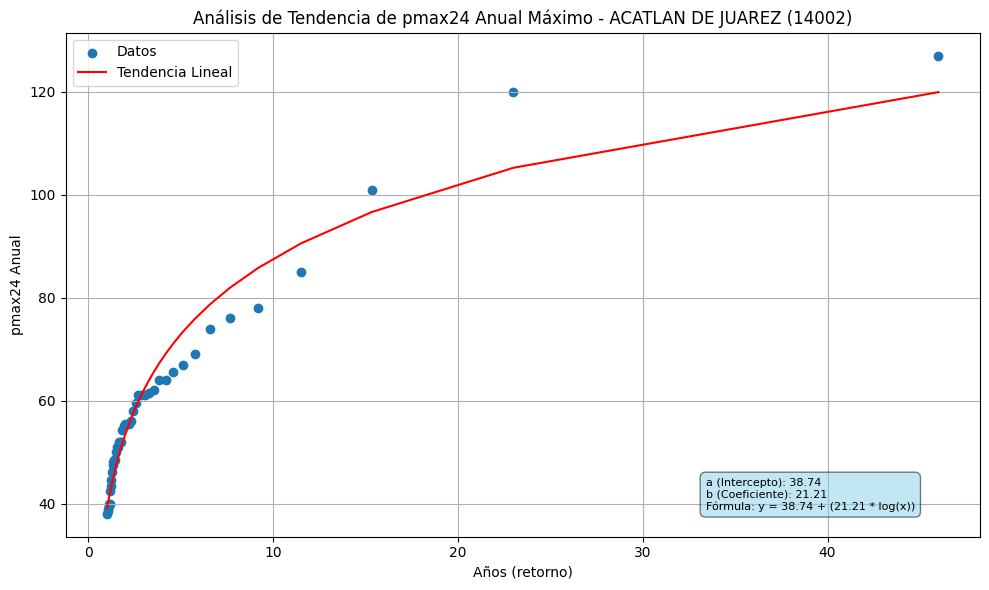

Scatter plot saved to /content/drive/My Drive/Clima_Jalisco/GRAFICOS_PMAX24/pmax24_ACATLAN DE JUAREZ_14002.png


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import os
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')

#Cargar Base de datos
file_path = '/content/drive/My Drive/Clima_Jalisco/estaciones_jalmes_FL.csv'
df_clima = pd.read_csv(file_path)
display(df_clima.head())
display(df_clima.info())

#Filtrar datos para ejemplo
df_filtered = df_clima[df_clima['Codigo'] == 14002].copy()
display(df_filtered.head())
display(df_filtered.info())

#Calculo de pmax24 anual
df_filtered['date'] = pd.to_datetime(df_filtered['date'])
df_filtered = df_filtered.set_index('date')
pmax24_annual_max = df_filtered['pmax24'].resample('AS').max()
pmax24_annual_max = pmax24_annual_max.dropna()
display(pmax24_annual_max.head())

#Preparar datos para análisis de tendencia
pmax24_sorted = pmax24_annual_max.sort_values(ascending=False)
df_sorted = pmax24_sorted.to_frame().reset_index()
n = len(df_sorted)
df_sorted['rank'] = range(1, n + 1)
df_sorted['probability'] = df_sorted['rank'] / (n + 1)
df_sorted['return_period'] = (n + 1) / df_sorted['rank']
display(df_sorted.head())

#Selección y ordenar variable por periodo de retorno
y = df_sorted['pmax24']
# Modified: Create X DataFrame using a dictionary
X = pd.DataFrame({'log_return_period': np.log(df_sorted['return_period'])})

display(X.head())
display(y.head())

# Check if X is empty before fitting the model
if not X.empty:
    #Cálculo de modelo
    modelo = LinearRegression()
    modelo.fit(X, y)
    print(f"Coeficiente: {modelo.coef_}")
    print(f"Intercepto: {modelo.intercept_}")

    # Generar el gráfico de tendencia
    fig, ax = plt.subplots(figsize=(10, 6)) # Create figure and axes
    ax.scatter(df_sorted['return_period'], y, label='Datos') # Use return period on the x-axis
    ax.plot(df_sorted['return_period'], modelo.predict(X), color='red', label='Tendencia Lineal') # Plot regression line against return period
    ax.set_xlabel('Años (retorno)') # Change x-axis label to 'Periodo de Retorno'
    ax.set_ylabel('pmax24 Anual')
    # Modified: Include site and code in the title
    site_name = df_filtered['site'].iloc[0] if not df_filtered.empty else 'Unknown Site'
    site_code = df_filtered['Codigo'].iloc[0] if not df_filtered.empty else 'Unknown Code'
    ax.set_title(f'TENDENCIA DE pmax24 ANUAL {site_name} ({site_code})')
    ax.legend()
    ax.grid(True)

    # Add model parameters and formula to the plot
    intercept = modelo.intercept_
    coef = modelo.coef_[0]
    formula = f'y = {intercept:.2f} + ({coef:.2f} * log(x))'
    textstr = f'a (Intercepto): {intercept:.2f}\nb (Coeficiente): {coef:.2f}\nFórmula: {formula}'
    ax.text(0.7, 0.05, textstr, transform=ax.transAxes, fontsize=8,
             verticalalignment='bottom', horizontalalignment='left', bbox=dict(boxstyle='round,pad=0.5', fc='skyblue', alpha=0.5))

    plt.tight_layout() # Adjust layout to prevent labels overlapping

    # Directorio para guardar resultados
    save_dir = '/content/drive/My Drive/Clima_Jalisco/GRAFICOS_PMAX24'
    os.makedirs(save_dir, exist_ok=True)
    file_path = os.path.join(save_dir, f'pmax24_{site_name}_{site_code}.png') # Changed filename

    # GUardar el gráfico de tendencia
    plt.savefig(file_path)

    # Display the plot in the notebook
    plt.show()

    plt.close(fig) # Close the figure using the figure object

    print(f"Scatter plot saved to {file_path}")
else:
    print("X is empty. Cannot fit the model.")